In [1]:
# libraries
import time
import biosppy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import warnings
warnings.filterwarnings('ignore')
import plotly
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from tqdm import tqdm 
from scipy import signal
from ripser import ripser, plot_dgms

#sliding window
from sliding.ecg_slider import ECGSlider
from sliding.SSlider import series_slider
#statistic wasserstein distance
from statistic.wasserstein_distance import WassersteinDistance, WassersteinDistanceDeviation
from Bootstrap.wasserstein_bootstrap import wasserstein_computation
#transformation
from transform.indexed_transform import IndexedTransformer
from transform.interpolate import SplineInterpolate
from transform.pca import PCATransformer
from transform.scale import ScaleTransform
from transform.series_to_curve import CurveProjection, IndicesWindow
from transform.transformer import SequentialTransformer
from transform.triangle_pattern import TrianglePattern
#artificial data
from Data_loader.data_loader import dataloader
from Data_loader.Artificial_data import artificial_data



enter number of peaks, noise level, arrhythmia type: False, True(fo random) or A_Flu,A_Fib,Sup_Tach,PAC,VR


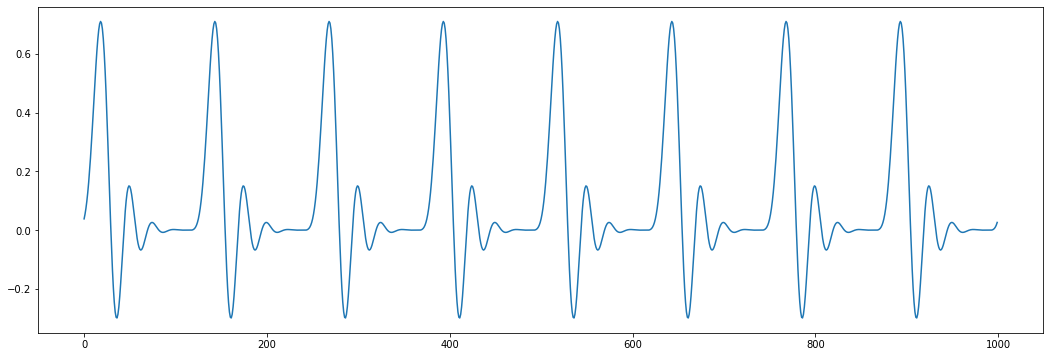

In [2]:
art=artificial_data(1,1,noise=0)
signal=art.create_rr(150,1,noise=0,arryhtmia=False)

plt.figure(figsize=(18,6))
plt.plot(signal[:1000])

### some function

f(x)=$2sin(2x)+a$

where $x$ is original signal

$a$ is some $const$

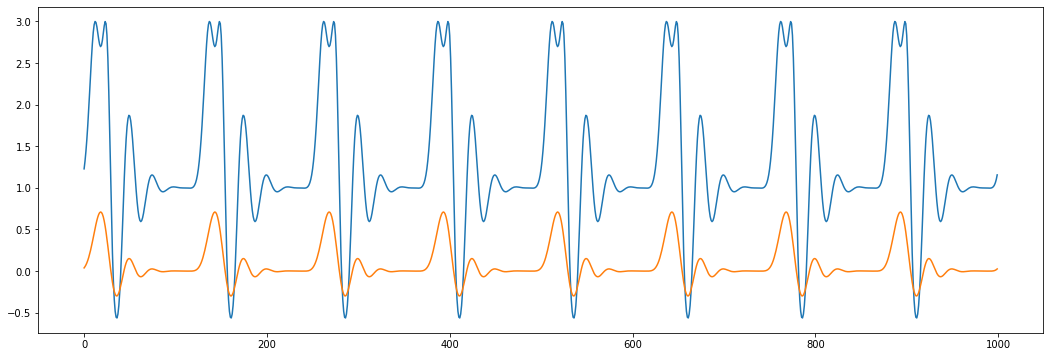

In [3]:
a=1
func=2*np.sin(3*signal)+a
plt.figure(figsize=(18,6))
plt.plot(func[:1000])
plt.plot(signal[:1000])

#### Functions for point clouds calculation

In [4]:
smooth_transform = SequentialTransformer(
    ScaleTransform(0, 1),
    SplineInterpolate(0.02)
)


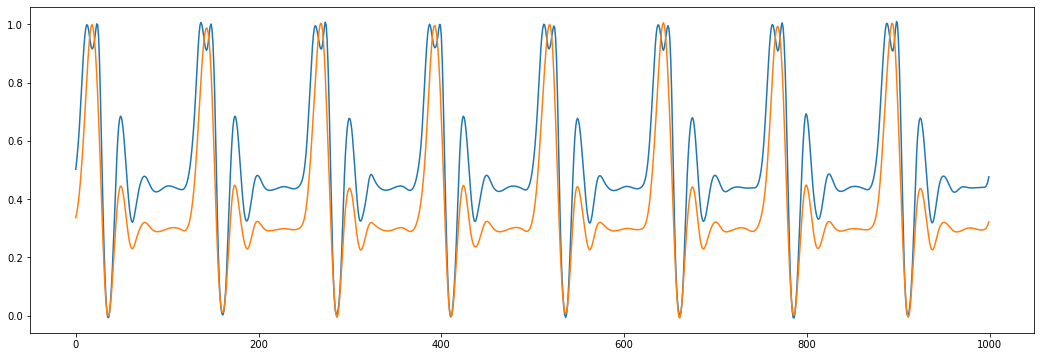

In [5]:
smooth_data_function=smooth_transform(func)
smooth_data_original=smooth_transform(signal)
plt.figure(figsize=(18,6))
plt.plot(smooth_data_function[:1000])
plt.plot(smooth_data_original[:1000])

In [6]:
# function which concate data slices from each signal
#input
# [sig1_0....sig1_n]
#[sig2_0....sig2_n]
#output
#[sig1_0,....sig1_n,sig2_0,....sig2_n]
def get_batch(data_1:list,data_2:list,batch_size=50):
    X=data_1
    y=data_2
    data=[]
    for batch in range(int(len(y)/batch_size)):
        idx = batch*batch_size
        indexes = slice(idx, idx + batch_size)
        data.append(np.concatenate((X[indexes], y[indexes])))
    return np.concatenate(data)

In [7]:
from tqdm import tqdm
def curves_computation(smooth_data_1,smooth_data_2,n_components:int,batch_size:int,window_size=20,step=1):
    if type(smooth_data_1)==np.ndarray and type(smooth_data_2)==np.ndarray:
        slider_1=ECGSlider(smooth_data_1,8,10).iterator()
        slider_2=ECGSlider(smooth_data_2,8,10).iterator()
        
    elif type(smooth_data_1)==pd.Series and type(smooth_data_2)==pd.Series:
        slider_1=series_slider(smooth_data_1,8,10).iterator()
        slider_2=series_slider(smooth_data_2,8,10).iterator()
        
    projection_step=1
    curve_transform = SequentialTransformer(
        CurveProjection(
            window=IndicesWindow.range(size=window_size, step=step),
            step=projection_step
        ),
        PCATransformer(n_components)
    )
    
    curves_combined=[]
    curves_signal_1=[]
    curves_signal_2=[]
    
    window_data_series=[]
   # diagrams=[]
    for signal_1,signal_2 in tqdm(zip(slider_1,slider_2)):
        
        first_signal=signal_1[1]
        second_signal=signal_2[1]

        window_data=get_batch(first_signal,second_signal,batch_size)

        transformed_curve_signal_1=curve_transform(np.array(first_signal))
        transformed_curve_signal_2=curve_transform(np.array(second_signal))
        transformed_curve_combined=curve_transform(window_data)

        curves_combined.append(transformed_curve_combined)
        curves_signal_1.append(transformed_curve_signal_1)
        curves_signal_2.append(transformed_curve_signal_2)
        
        window_data_series.append([first_signal,second_signal])

    return curves_combined,curves_signal_1,curves_signal_2,window_data_series
    

In [9]:
curves_combined,curves_signal_1,curves_signal_2,window_data_series=curves_computation(smooth_data_original,smooth_data_function,n_components=6,batch_size=50,window_size=100)

136it [00:18,  7.40it/s]


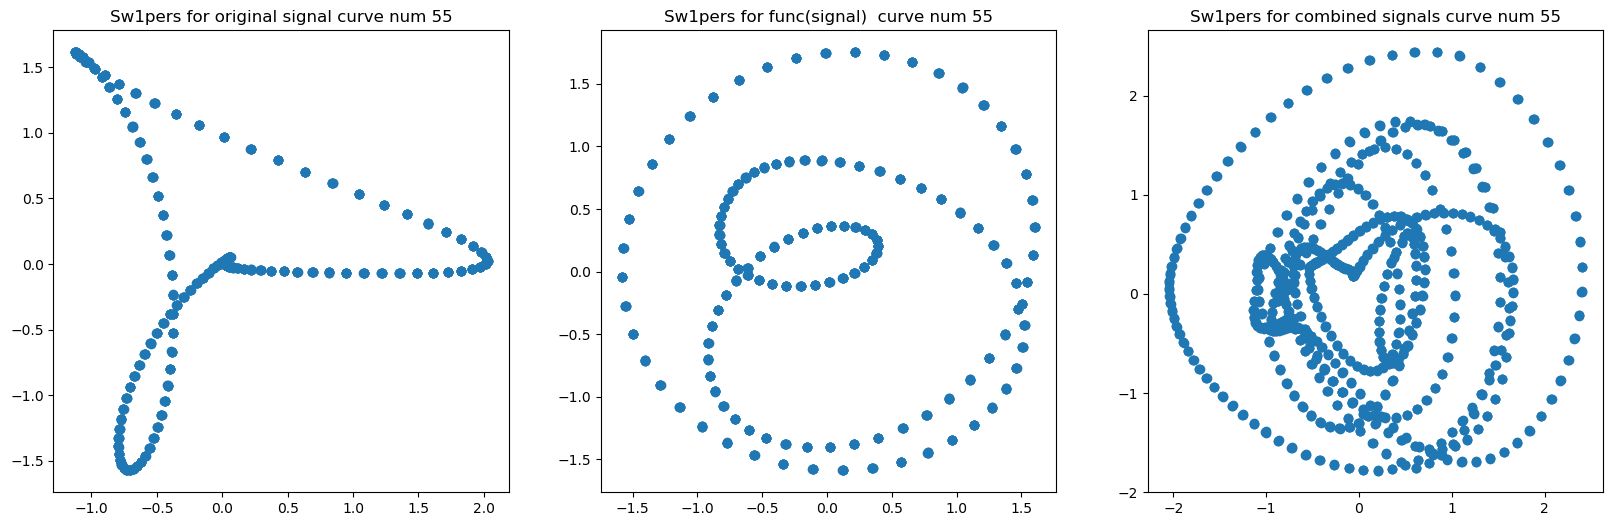

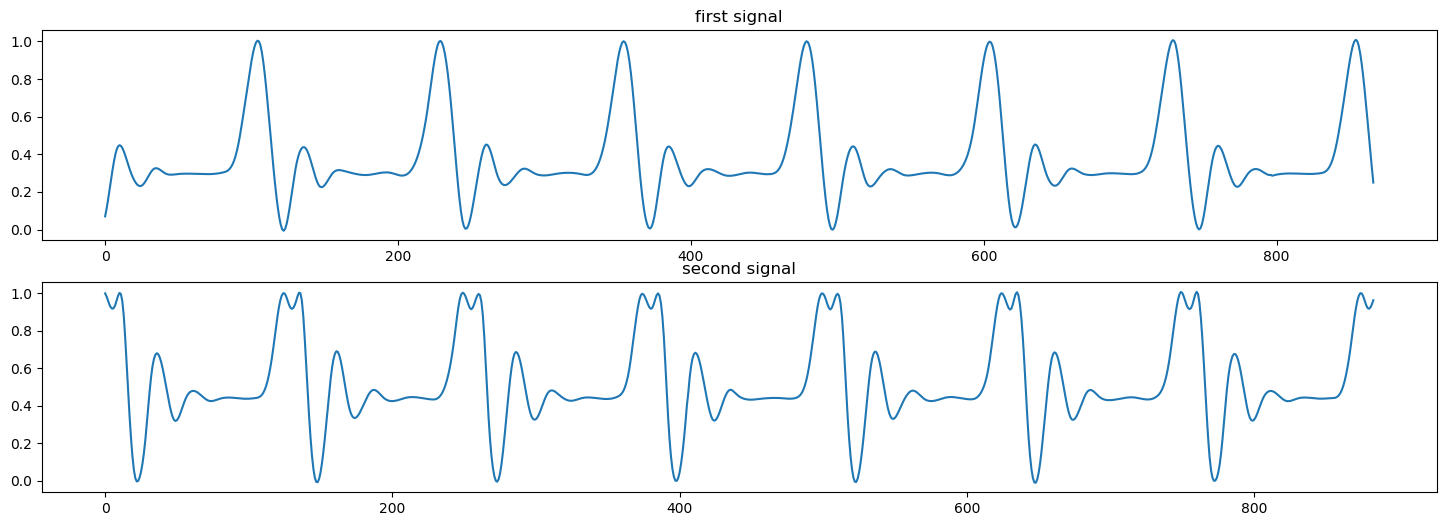

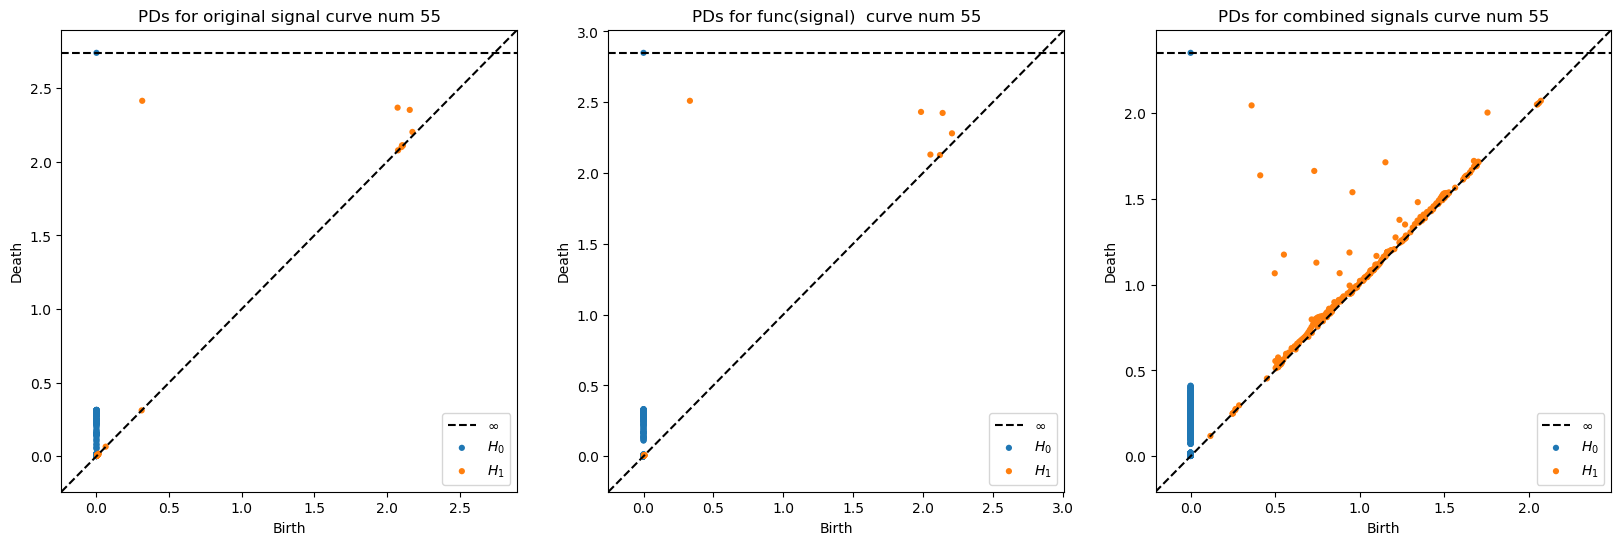

In [28]:
num=55
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.scatter(curves_signal_1[num][:,0],curves_signal_1[num][:,1])
plt.title('Sw1pers for original signal '+'curve num '+str(num))
plt.subplot(132)
plt.scatter(curves_signal_2[num][:,0],curves_signal_2[num][:,1])
plt.title('Sw1pers for func(signal)  '+'curve num '+str(num))
plt.subplot(133)
plt.scatter(curves_combined[num][:,0],curves_combined[num][:,1])
plt.title('Sw1pers for combined signals '+'curve num '+str(num))
plt.show()

plt.figure(figsize=(18,6))
plt.subplot(211)
plt.plot(window_data_series[num][0])
plt.title('first signal')
plt.subplot(212)
plt.plot(window_data_series[num][1])
plt.title('second signal')
plt.show()


plt.figure(figsize=(20,6))
plt.subplot(131)
PDs = ripser(curves_signal_1[num], maxdim=1)['dgms']
plt.title('PDs for original signal '+'curve num '+str(num))
plot_dgms(PDs)
plt.subplot(132)
PDs = ripser(curves_signal_2[num], maxdim=1)['dgms']
plt.title('PDs for func(signal)  '+'curve num '+str(num))
plot_dgms(PDs)
plt.subplot(133)
PDs = ripser(curves_combined[num], maxdim=1)['dgms']
plt.title('PDs for combined signals '+'curve num '+str(num))
plot_dgms(PDs)

## Time change: 1, index=index*const

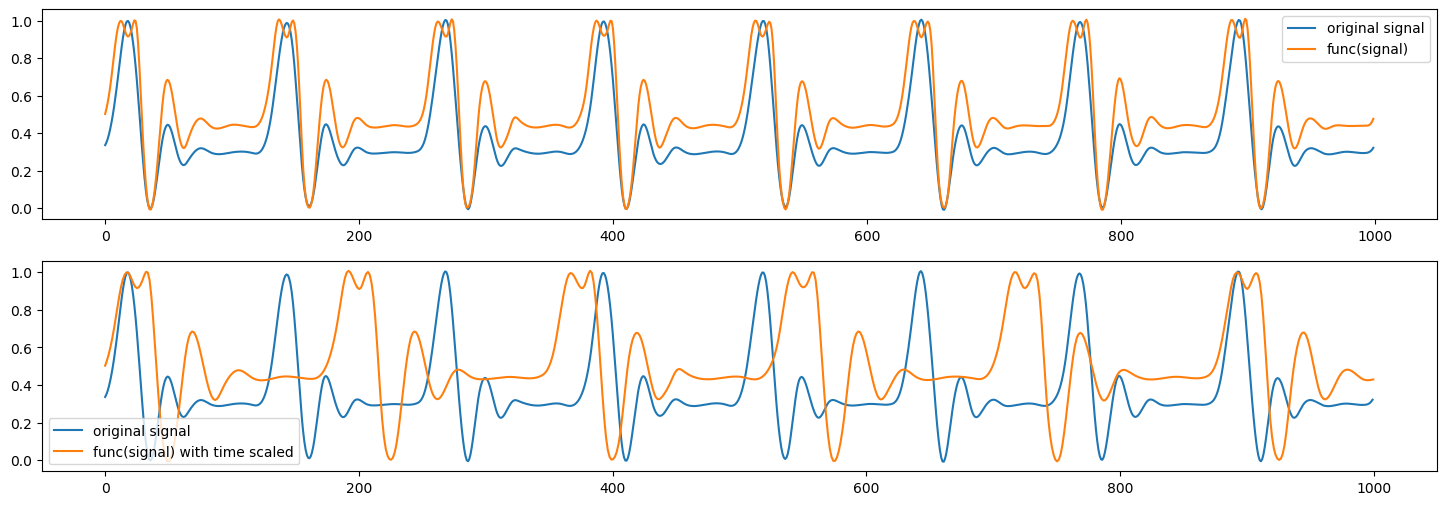

In [11]:
const=1.4
signal_series=pd.Series(smooth_data_original)
func_series=pd.Series(smooth_data_function)
func_series.index=func_series.index*const

plt.figure(figsize=(18,6))
plt.subplot(211)
plt.plot(smooth_data_original[:1000],label='original signal')
plt.plot(smooth_data_function[:1000],label='func(signal)')
plt.legend()

plt.subplot(212)
plt.plot(signal_series[:1000],label='original signal')
plt.plot(func_series[:1000],label='func(signal) with time scaled')
plt.legend()

In [12]:
curves_combined_,curves_signal_1_,curves_signal_2_,window_data_series_=curves_computation(signal_series,func_series,n_components=6,batch_size=50,window_size=100)

136it [00:18,  7.19it/s]


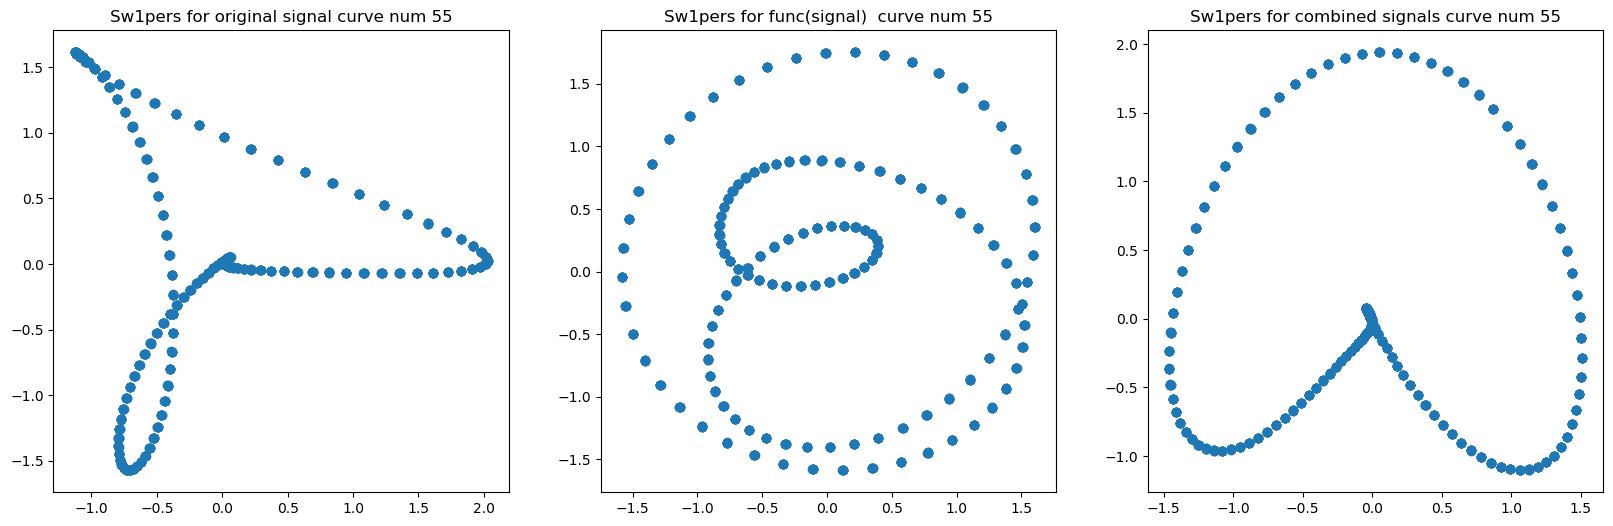

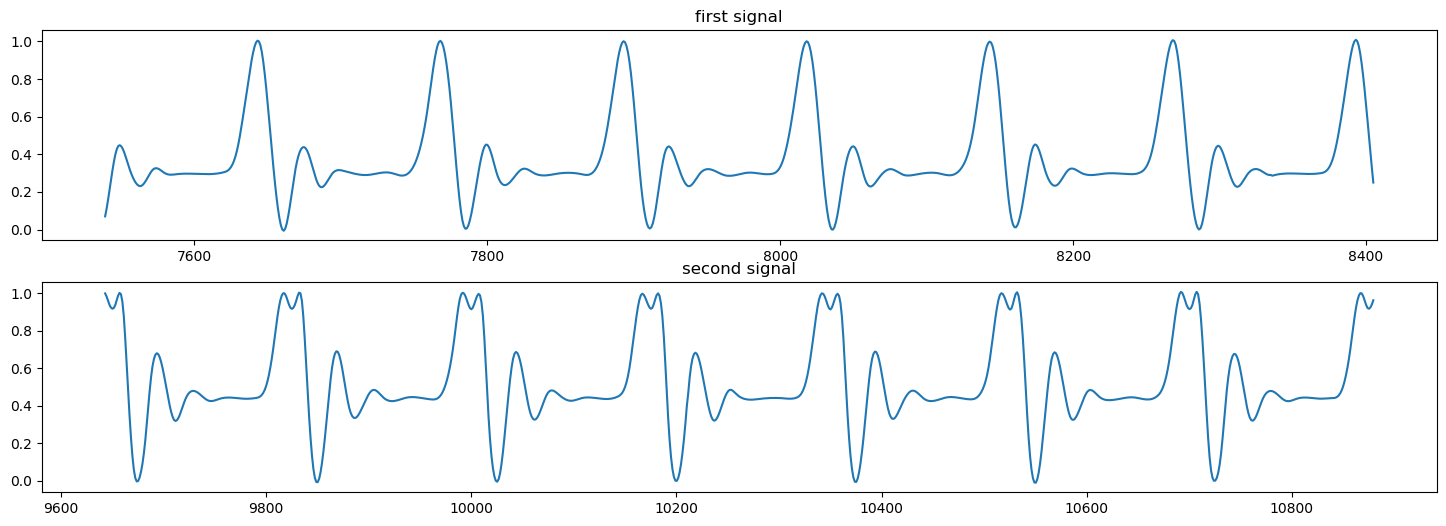

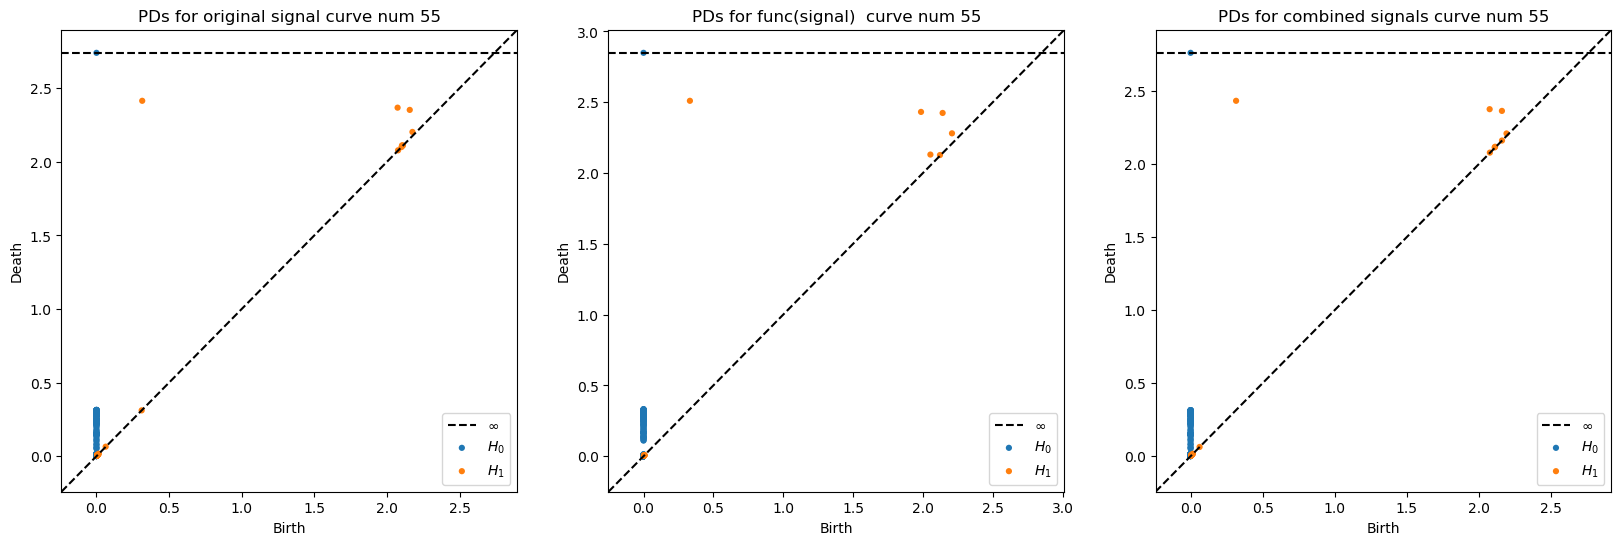

In [29]:
num=55
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.scatter(curves_signal_1_[num][:,0],curves_signal_1_[num][:,1])
plt.title('Sw1pers for original signal '+'curve num '+str(num))
plt.subplot(132)
plt.scatter(curves_signal_2_[num][:,0],curves_signal_2_[num][:,1])
plt.title('Sw1pers for func(signal)  '+'curve num '+str(num))
plt.subplot(133)
plt.scatter(curves_combined_[num][:,0],curves_combined_[num][:,1])
plt.title('Sw1pers for combined signals '+'curve num '+str(num))
plt.show()

plt.figure(figsize=(18,6))
plt.subplot(211)
plt.plot(window_data_series_[num][0])
plt.title('first signal')
plt.subplot(212)
plt.plot(window_data_series_[num][1])
plt.title('second signal')
plt.show()


plt.figure(figsize=(20,6))
plt.subplot(131)
PDs = ripser(curves_signal_1_[num], maxdim=1)['dgms']
plt.title('PDs for original signal '+'curve num '+str(num))
plot_dgms(PDs)
plt.subplot(132)
PDs = ripser(curves_signal_2_[num], maxdim=1)['dgms']
plt.title('PDs for func(signal)  '+'curve num '+str(num))
plot_dgms(PDs)
plt.subplot(133)
PDs = ripser(curves_combined_[num], maxdim=1)['dgms']
plt.title('PDs for combined signals '+'curve num '+str(num))
plot_dgms(PDs)

## ind = ind + C_1*sin(C_2*ind)

$C_1$ and $C_2$ are small

In [253]:
const_1=0.03
const_2=10

signal_series=pd.Series(smooth_data_original)
func_series=pd.Series(smooth_data_function)
func_series.index=func_series.index+const_2+np.sin(const_1*func_series.index)

In [254]:
func_series.index

Float64Index([              10.0, 11.029995500202496, 12.059964006479445,
               13.08987854919801,  14.11971220728892,   15.1494381324736,
              16.179029573425826,   17.2084598998461, 18.237702626427133,
              19.266731436688833,
              ...
               18750.14457652984, 18751.114831119157,  18752.08498236822,
               18753.05505713888, 18754.025082361837,  18754.99508501236,
              18755.965092086044,  18756.93513057449,  18757.90522744104,
              18758.875409596498],
             dtype='float64', length=18750)

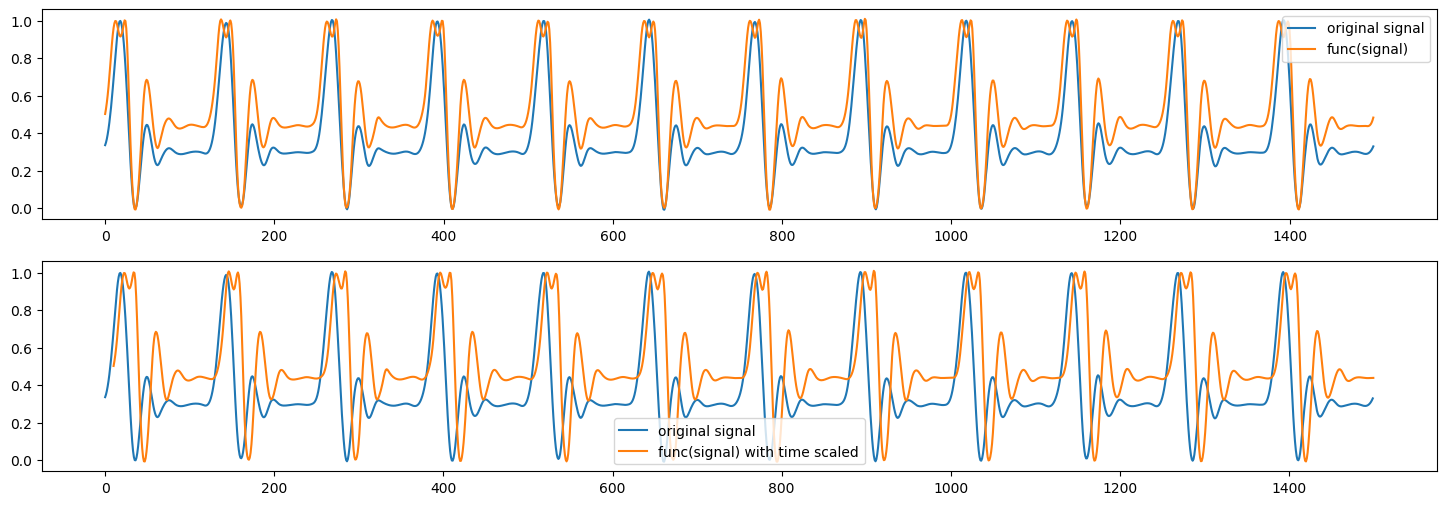

In [255]:
plt.figure(figsize=(18,6))
plt.subplot(211)
plt.plot(smooth_data_original[:1500],label='original signal')
plt.plot(smooth_data_function[:1500],label='func(signal)')
plt.legend()

plt.subplot(212)
plt.plot(signal_series[:1500],label='original signal')
plt.plot(func_series[:1500],label='func(signal) with time scaled')
plt.legend()

In [257]:
curves_combined,curves_signal_1,curves_signal_2,window_data_series=curves_computation(signal_series,func_series,n_components=10,batch_size=50,window_size=100)


136it [00:20,  6.66it/s]


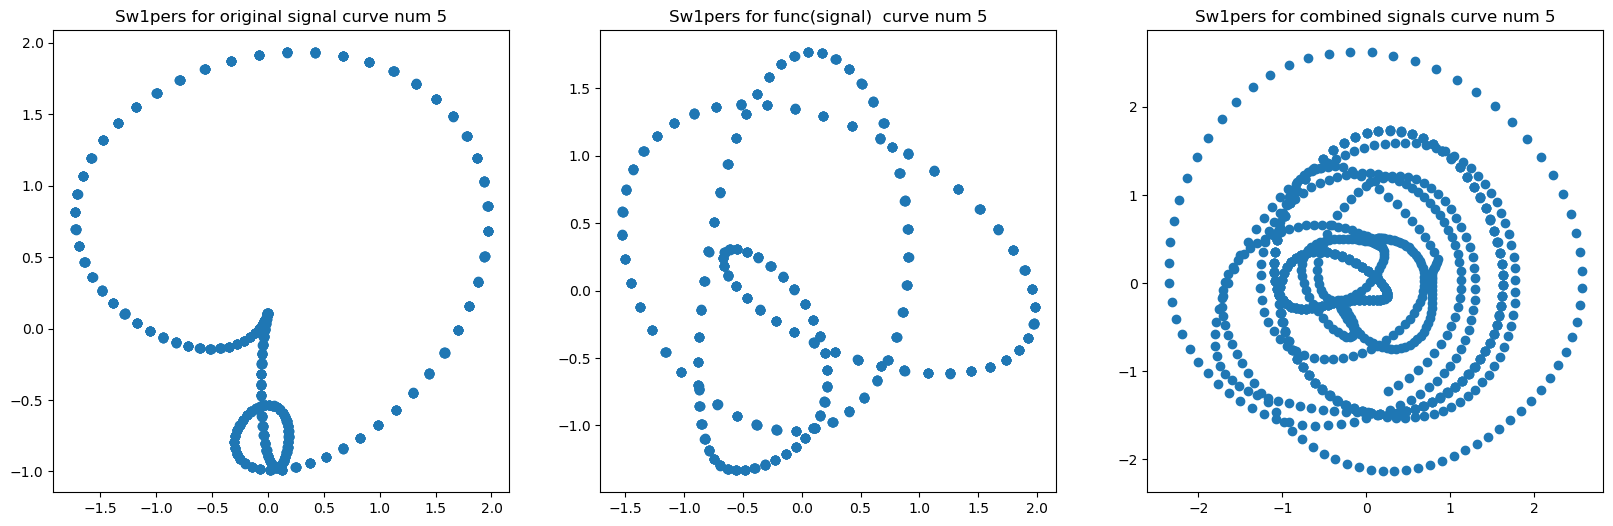

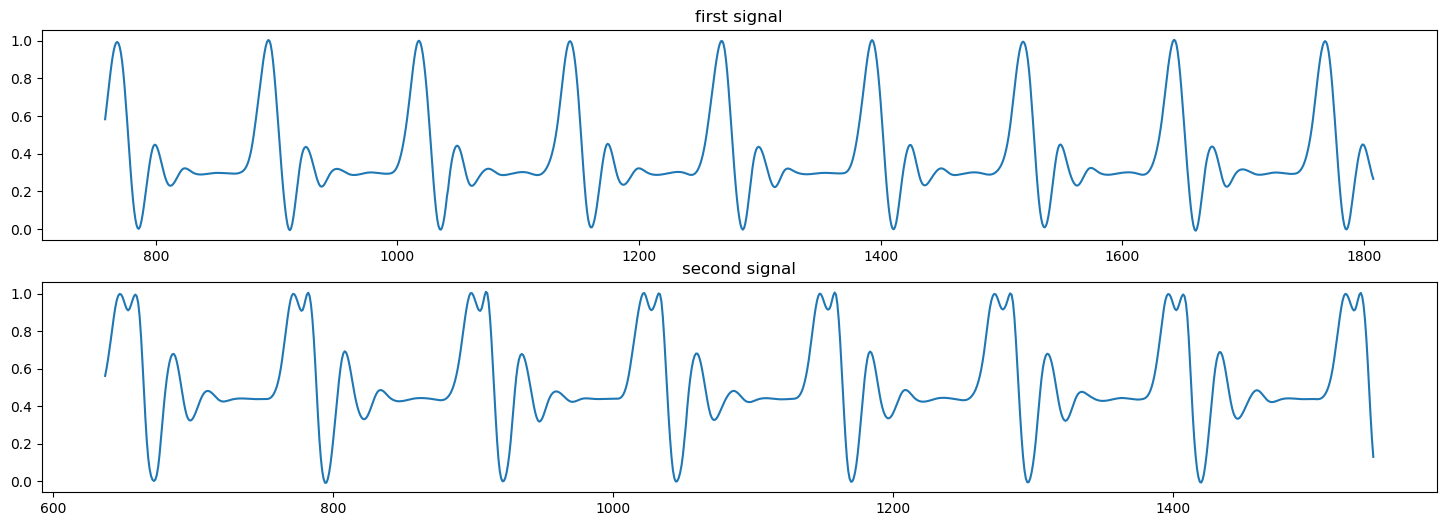

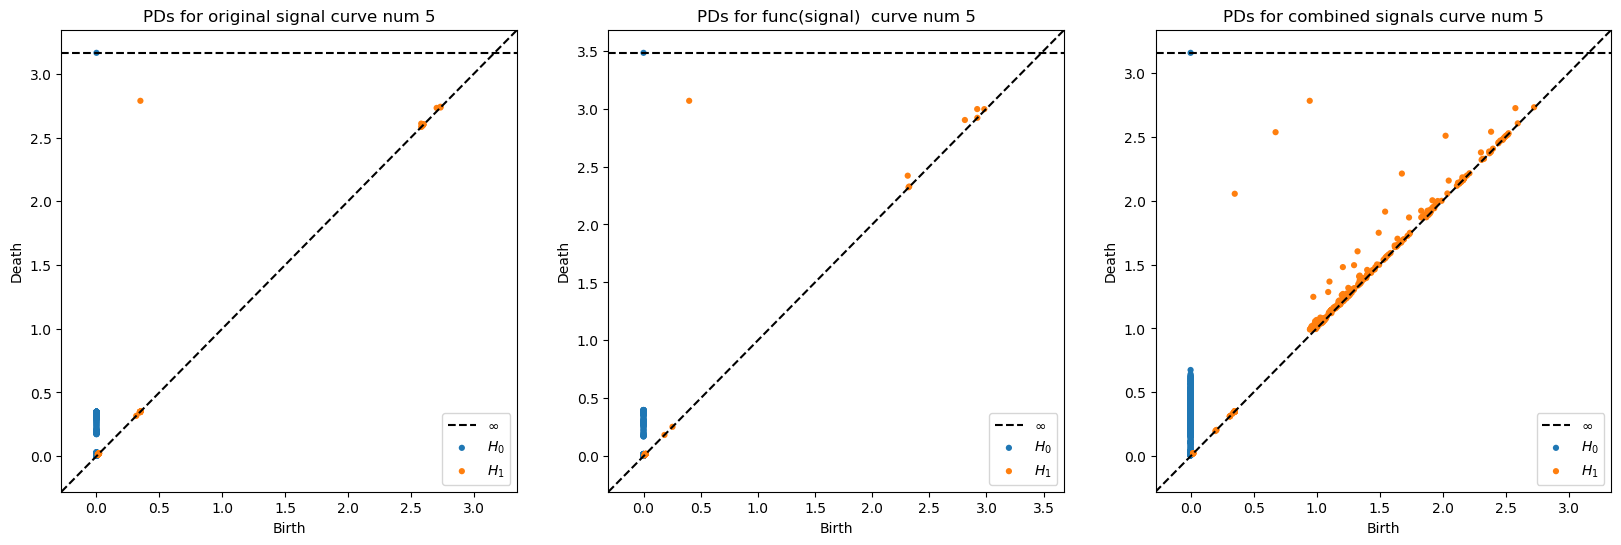

In [258]:
num=5
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.scatter(curves_signal_1[num][:,0],curves_signal_1[num][:,1])
plt.title('Sw1pers for original signal '+'curve num '+str(num))
plt.subplot(132)
plt.scatter(curves_signal_2[num][:,0],curves_signal_2[num][:,1])
plt.title('Sw1pers for func(signal)  '+'curve num '+str(num))
plt.subplot(133)
plt.scatter(curves_combined[num][:,0],curves_combined[num][:,1])
plt.title('Sw1pers for combined signals '+'curve num '+str(num))
plt.show()


plt.figure(figsize=(18,6))
plt.subplot(211)
plt.plot(window_data_series[num][0])
plt.title('first signal')
plt.subplot(212)
plt.plot(window_data_series[num][1])
plt.title('second signal')
plt.show()

plt.figure(figsize=(20,6))
plt.subplot(131)
PDs = ripser(curves_signal_1[num], maxdim=1)['dgms']
plt.title('PDs for original signal '+'curve num '+str(num))
plot_dgms(PDs)
plt.subplot(132)
PDs = ripser(curves_signal_2[num], maxdim=1)['dgms']
plt.title('PDs for func(signal)  '+'curve num '+str(num))
plot_dgms(PDs)
plt.subplot(133)
PDs = ripser(curves_combined[num], maxdim=1)['dgms']
plt.title('PDs for combined signals '+'curve num '+str(num))
plot_dgms(PDs)

also was made experiments, with $ind=ind+random$ but results similar to previous